In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
inversion_result = np.load("output/inversion_result_0.npy")
inversion_result.shape

(971, 1600, 8)

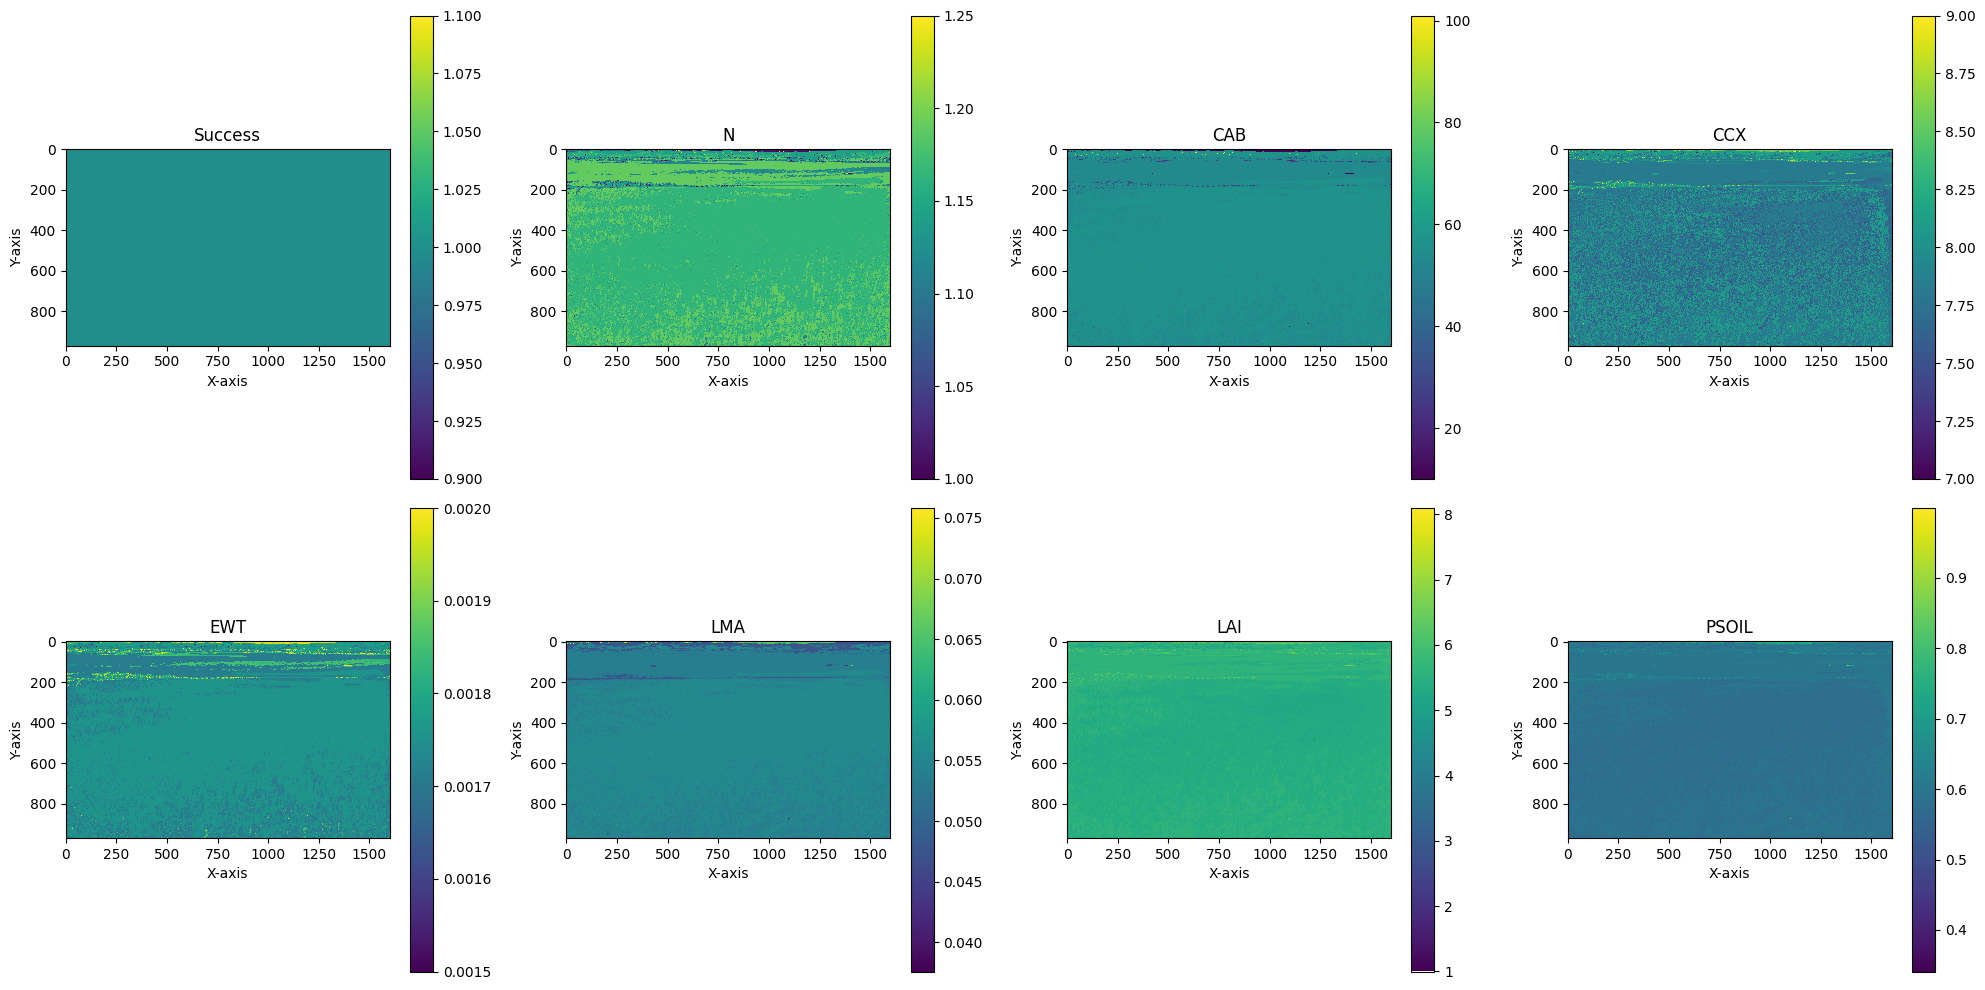

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

labels = ("Success", "N", "CAB", "CCX", "EWT", "LMA", "LAI", "PSOIL")

for i in range(8):
    ax = axes[i // 4, i % 4]
    cax = ax.imshow(inversion_result[:, :, i], cmap='viridis', interpolation='nearest')
    ax.set_title(labels[i])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()